## Twitter Sentiment Analysis for US Airlines

#### It is a (multi- class) classifictaion problem where we attempt to classify a particular tweet into 3 labels: 'positive', 'negative' or 'neutral'. Attempted techniques: Deep Learning (LSTM and GRU), Random Forest, XGBoost and Multinomila Logistic Regression. Metrics used to observe the performance: accuracy suported by confusion matrix to investigate the performance across all 3 labels as well.

In [49]:
#relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding

from sklearn.model_selection import train_test_split


In [50]:
# input tweets data
tweets=pd.read_csv("Tweets.csv")
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [51]:
# keep relevant variables for classification of sentiments- sentiment & tweet text

tweets_data=tweets[['airline_sentiment','text']]
tweets_data.shape
# data has 14,640 observations

(14640, 2)

In [52]:
#check for missingness
tweets_data.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [53]:
# convert string sentiment categories to numeric data
tweets_data['sentiment_type']=tweets_data['airline_sentiment'].replace({'positive':2,'neutral':1,'negative':0})
tweets_data.head()

C:\Users\aditi\Anaconda3_3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text,sentiment_type
0,neutral,@VirginAmerica What @dhepburn said.,1
1,positive,@VirginAmerica plus you've added commercials t...,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [54]:
X=tweets_data['text']
y=tweets_data['sentiment_type']

### Preprocessing data

In [55]:
#tokenize the text 
token=Tokenizer()
token.fit_on_texts(X)

In [56]:
# Find number of unique words in our tweets
vocab_size = len(token.word_index)+1
vocab_size

15769

In [57]:
# integer encode tweets' text
sequences = token.texts_to_sequences(X)
#sequences

In [58]:
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

tweet_maxlength = max_tweet()
tweet_maxlength

30

In [59]:
#substituting lesser length's sequences with 0 to make all sequences of equal lengths
padded_X = pad_sequences(sequences, padding='post', maxlen=tweet_maxlength)

In [60]:
#One-hot Encoding for airline sentiment
labels = to_categorical(np.asarray(y))
labels

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [61]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.3, random_state = 1011)

### Word Embedding using Pre- trained GloVe Embedding

In [62]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# used 100 dimensional version (embedding dimension)- load into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [63]:
# create a "weight matrix" for words using the unique words in our training data and their GloVe vector representation

embedding_matrix = np.zeros((vocab_size, 100))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
# Create embedding layer using GloVe embedding weights
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_maxlength, trainable=False) # since we do want to update the word weights

### Modeling

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

### 1. Long Short- term Memory (LSTM)

#### Hyper-parameters: no. of layers, output dimension per layer, regularization: drpout and recurrent dropout rates per layer

##### Model 1- (dim= 256 (first layer), dropout=0.2, recurrent dropout=0.5)


In [19]:
# define model
mod1 = Sequential()
mod1.add(embedding_layer)
mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod1.add(Dense(3, activation='softmax')) # dense vector of 3 nodes for 3 labels
# compile the model
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [20]:
# summarize the model
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [21]:
# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_1 = mod1.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

In [22]:
# Insample & OOS model performance
loss, accuracy = mod1.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod1.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

Training Accuracy: 89.422327
Testing Accuracy: 80.214024


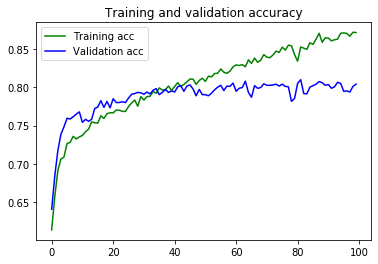

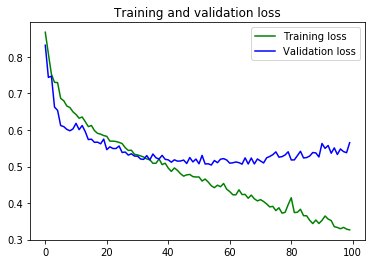

In [23]:
# Plot train/test loss and accuracy
acc = model_1.history['acc']
val_acc = model_1.history['val_acc']
loss = model_1.history['loss']
val_loss = model_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [25]:
# Get predicted values
y_pred = mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [26]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [27]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[2511  186   63]
 [ 281  565   78]
 [ 160  101  447]]
Normalized confusion matrix
[[0.91 0.07 0.02]
 [0.3  0.61 0.08]
 [0.23 0.14 0.63]]


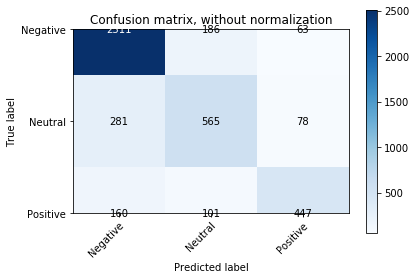

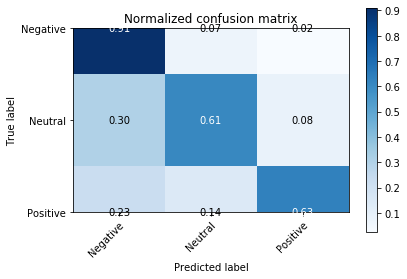

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Reduced dimensionality

##### Model 2- (dim= 128 (first layer), dropout=0.2, recurrent dropout=0.5)

In [29]:
# define model
mod2 = Sequential()
mod2.add(embedding_layer)
mod2.add(LSTM(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod2.add(Dense(3, activation='softmax')) 
# compile the model
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
mod2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,694,535
Trainable params: 117,635
Non-trainable params: 1,576,900
_________________________________________________________________


In [30]:
# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_2 = mod2.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

Training Accuracy: 86.992586
Testing Accuracy: 79.826957


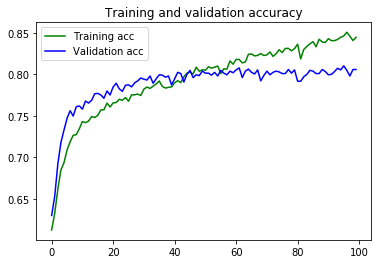

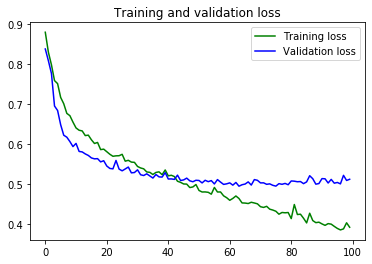

In [31]:
# Insample & OOS model performance
loss, accuracy = mod2.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod2.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_2.history['acc']
val_acc = model_2.history['val_acc']
loss = model_2.history['loss']
val_loss = model_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
# Get predicted values
y_pred = mod2.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[2454  213   93]
 [ 254  573   97]
 [ 129  100  479]]
Normalized confusion matrix
[[0.89 0.08 0.03]
 [0.27 0.62 0.1 ]
 [0.18 0.14 0.68]]


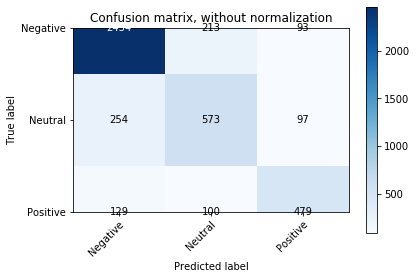

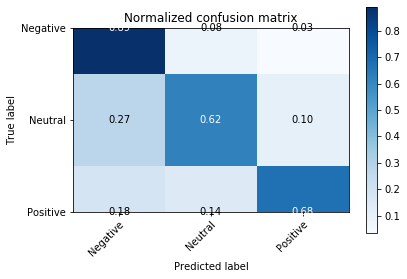

In [33]:

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Reduced dimensionality, added layer (Stacking)

##### Model 3- (dim= 64 (first layer), 128(second layer), dropout=0.2, recurrent dropout=0.5)

In [34]:
# define model
mod3 = Sequential()
mod3.add(embedding_layer)
mod3.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
               return_sequences = True))
mod3.add(LSTM(128, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod3.add(Dense(3, activation='softmax')) 

# compile the model
mod3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
mod3.summary()

# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_3 = mod3.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            42240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 1,718,343
Trainable params: 141,443
Non-trainable params: 1,576,900
_________________________________________________________________


Training Accuracy: 86.855972
Testing Accuracy: 80.054647


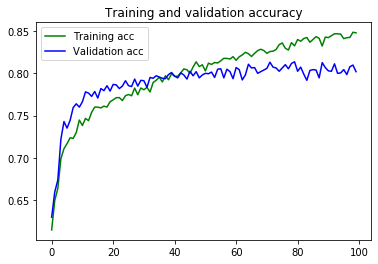

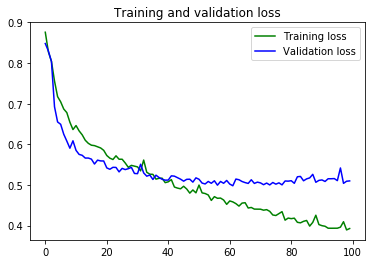

In [38]:
# Insample & OOS model performance
loss, accuracy = mod3.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod3.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_3.history['acc']
val_acc = model_3.history['val_acc']
loss = model_3.history['loss']
val_loss = model_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Confusion matrix, without normalization
[[2440  201  119]
 [ 244  564  116]
 [ 108   88  512]]
Normalized confusion matrix
[[0.88 0.07 0.04]
 [0.26 0.61 0.13]
 [0.15 0.12 0.72]]


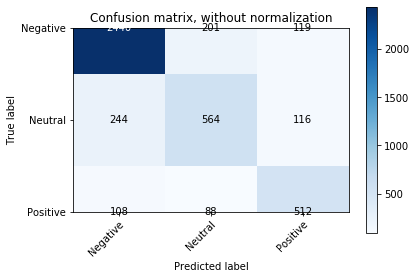

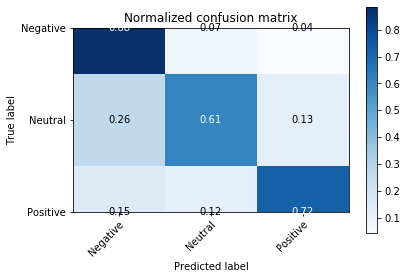

In [36]:
# Get predicted values
y_pred = mod3.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Model 4- (dim= 64 (first layer), 64(second layer), dropout=0.2, recurrent dropout=0.5)

In [39]:
# define model
mod4 = Sequential()
mod4.add(embedding_layer)
mod4.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
               return_sequences = True))
mod4.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
mod4.add(Dense(3, activation='softmax')) 

# compile the model
mod4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# summarize the model
mod4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,652,359
Trainable params: 75,459
Non-trainable params: 1,576,900
_________________________________________________________________


In [40]:
# fit the model keeping 20% data for validation. Trained for 100 epochs and batch sze of 256
model_4 = mod4.fit(X_train,y_train, validation_split=0.2, epochs=100, verbose=0, batch_size=256)

Training Accuracy: 86.914521
Testing Accuracy: 79.758650


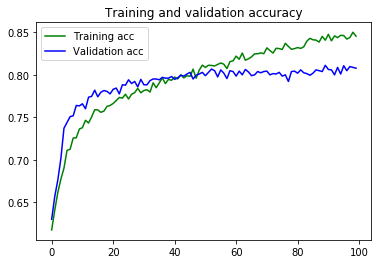

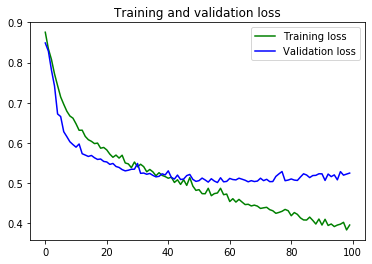

Confusion matrix, without normalization
[[2475  184  101]
 [ 279  542  103]
 [ 121  101  486]]
Normalized confusion matrix
[[0.9  0.07 0.04]
 [0.3  0.59 0.11]
 [0.17 0.14 0.69]]


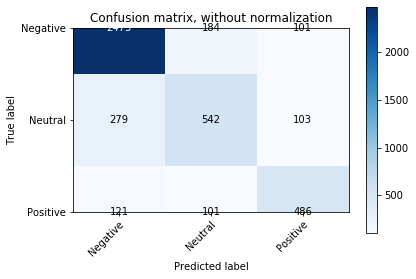

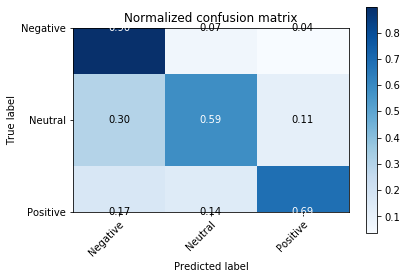

In [41]:
# Insample & OOS model performance
loss, accuracy = mod4.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod4.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_4.history['acc']
val_acc = model_4.history['val_acc']
loss = model_4.history['loss']
val_loss = model_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Get predicted values
y_pred = mod4.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Out of the 4 LSTM models- model 3 appears to perform the best with least overfitting in validation data, relatively good out of sample accuracy and target capture in the 3 labels

### Gradient Recurrent Unit

#### Model 5

In [45]:
mod5 = Sequential()
mod5.add(embedding_layer)
mod5.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
mod5.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
mod5.add(Dense(3, activation='softmax'))
mod5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mod5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 256)           274944    
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387       
Total params: 2,000,455
Trainable params: 423,555
Non-trainable params: 1,576,900
_________________________________________________________________


In [47]:
# use less epochs as we observe overfitting post that point in above models

model_5 = mod5.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, verbose=0, batch_size=256)

Training Accuracy: 94.652617
Testing Accuracy: 79.348814


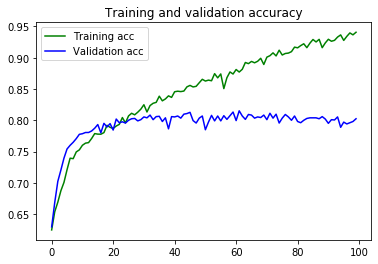

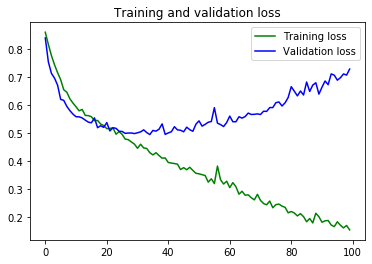

Confusion matrix, without normalization
[[2528  151   81]
 [ 320  479  125]
 [ 144   86  478]]
Normalized confusion matrix
[[0.92 0.05 0.03]
 [0.35 0.52 0.14]
 [0.2  0.12 0.68]]


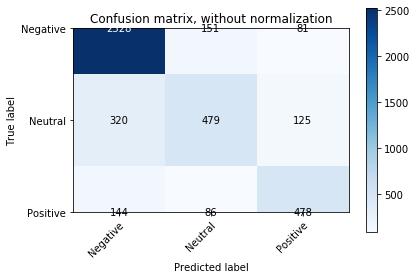

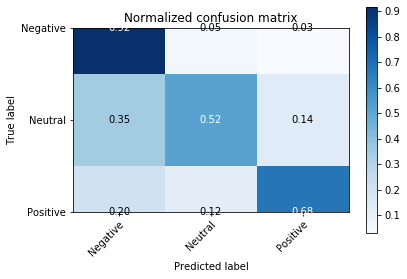

In [48]:
# Insample & OOS model performance
loss, accuracy = mod5.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod5.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_5.history['acc']
val_acc = model_5.history['val_acc']
loss = model_5.history['loss']
val_loss = model_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Get predicted values
y_pred = mod5.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Model 6

In [67]:
mod6 = Sequential()
mod6.add(embedding_layer)
mod6.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
mod6.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
mod6.add(Dense(3, activation='softmax'))
mod6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mod6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
gru_8 (GRU)                  (None, 30, 64)            31872     
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               74496     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,683,655
Trainable params: 106,755
Non-trainable params: 1,576,900
_________________________________________________________________


In [68]:
model_6 = mod6.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=80, verbose=0, batch_size=256)

Training Accuracy: 85.558158
Testing Accuracy: 80.282331


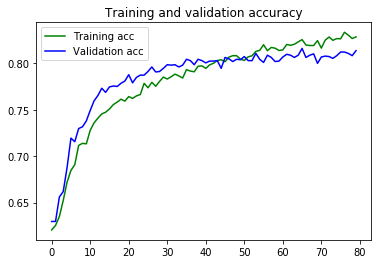

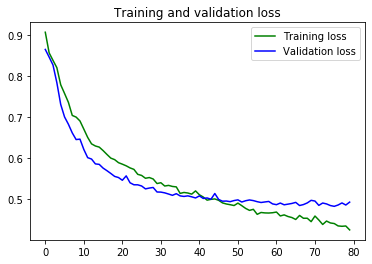

Confusion matrix, without normalization
[[2533  144   83]
 [ 308  501  115]
 [ 135   81  492]]
Normalized confusion matrix
[[0.92 0.05 0.03]
 [0.33 0.54 0.12]
 [0.19 0.11 0.69]]


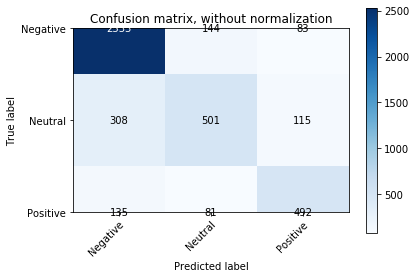

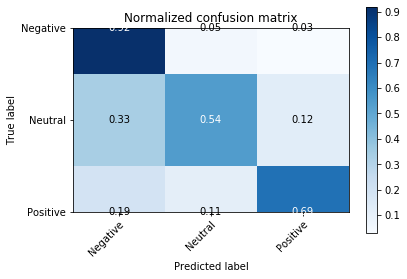

In [69]:
# Insample & OOS model performance
loss, accuracy = mod6.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod6.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_6.history['acc']
val_acc = model_6.history['val_acc']
loss = model_6.history['loss']
val_loss = model_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Get predicted values
y_pred = mod6.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Model 7

In [70]:
mod7 = Sequential()
mod7.add(embedding_layer)
mod7.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
mod7.add(GRU(64,
                dropout = 0.2,
                recurrent_dropout = 0.5))
mod7.add(Dense(3, activation='softmax'))
mod7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mod7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
gru_10 (GRU)                 (None, 30, 64)            31872     
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
Total params: 1,633,927
Trainable params: 57,027
Non-trainable params: 1,576,900
_________________________________________________________________


In [71]:
model_7 = mod7.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=60, verbose=0, batch_size=256)

Training Accuracy: 83.323574
Testing Accuracy: 80.441713


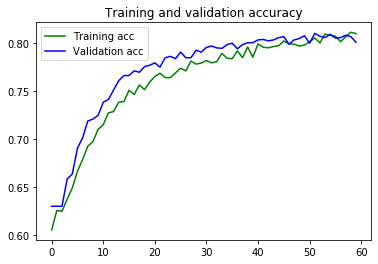

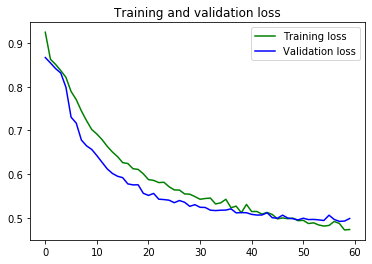

Confusion matrix, without normalization
[[2446  211  103]
 [ 244  582   98]
 [ 110   93  505]]
Normalized confusion matrix
[[0.89 0.08 0.04]
 [0.26 0.63 0.11]
 [0.16 0.13 0.71]]


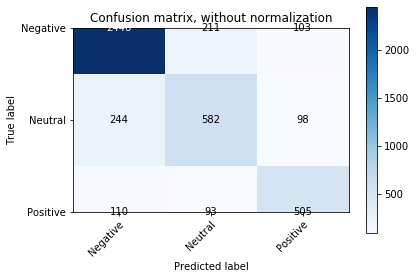

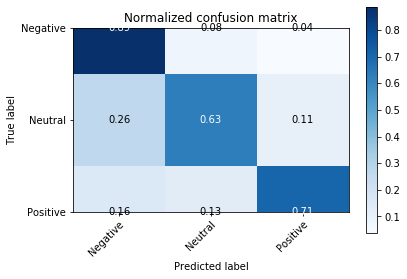

In [72]:
# Insample & OOS model performance
loss, accuracy = mod7.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod7.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_7.history['acc']
val_acc = model_7.history['val_acc']
loss = model_7.history['loss']
val_loss = model_7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Get predicted values
y_pred = mod7.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


#### Model 8

In [76]:
mod8 = Sequential()
mod8.add(embedding_layer)
mod8.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
mod8.add(GRU(32,
                dropout = 0.2,
                recurrent_dropout = 0.5))
mod8.add(Dense(3, activation='softmax'))
mod8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
mod8.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1576900   
_________________________________________________________________
gru_14 (GRU)                 (None, 30, 64)            31872     
_________________________________________________________________
gru_15 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 1,618,279
Trainable params: 41,379
Non-trainable params: 1,576,900
_________________________________________________________________


In [77]:
model_8 = mod8.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=60, verbose=0, batch_size=256)

Training Accuracy: 82.913738
Testing Accuracy: 79.530966


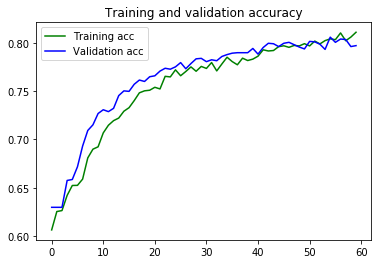

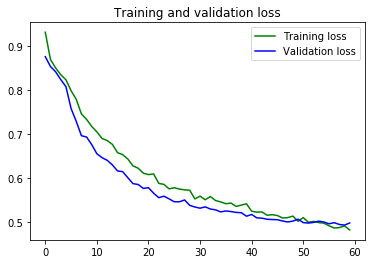

Confusion matrix, without normalization
[[2468  197   95]
 [ 279  547   98]
 [ 129  101  478]]
Normalized confusion matrix
[[0.89 0.07 0.03]
 [0.3  0.59 0.11]
 [0.18 0.14 0.68]]


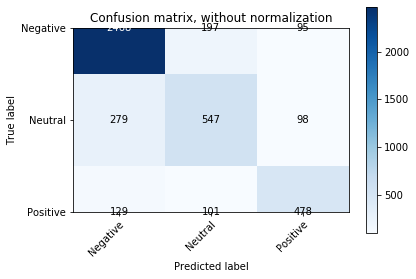

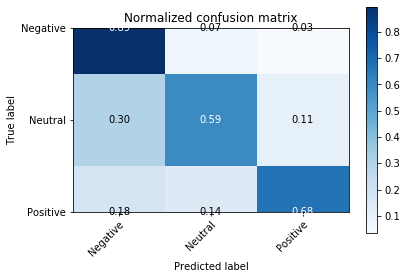

In [78]:
# Insample & OOS model performance
loss, accuracy = mod8.evaluate(X_train, y_train, verbose=0)
print('Training Accuracy: %f' % (accuracy*100))
loss, accuracy = mod8.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy: %f' % (accuracy*100))

# Plot train/test loss and accuracy
acc = model_8.history['acc']
val_acc = model_8.history['val_acc']
loss = model_8.history['loss']
val_loss = model_8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Get predicted values
y_pred = mod8.predict(X_test)  
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 7 appears to display the best results in terms of less overfitting in validation data, testing accuracy and the percentage text correctly captured within each category